In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import common_config

In [2]:
common_config.figure_journal_basic()

color_palette = {
    "CPU": common_config.rsc_grey,
    "L40s": common_config.rsc_lightgreen,
    "H200": common_config.rsc_darkgreen,
    "B200": common_config.rsc_blue,
    "RTX 6000": common_config.rsc_turquise,
}

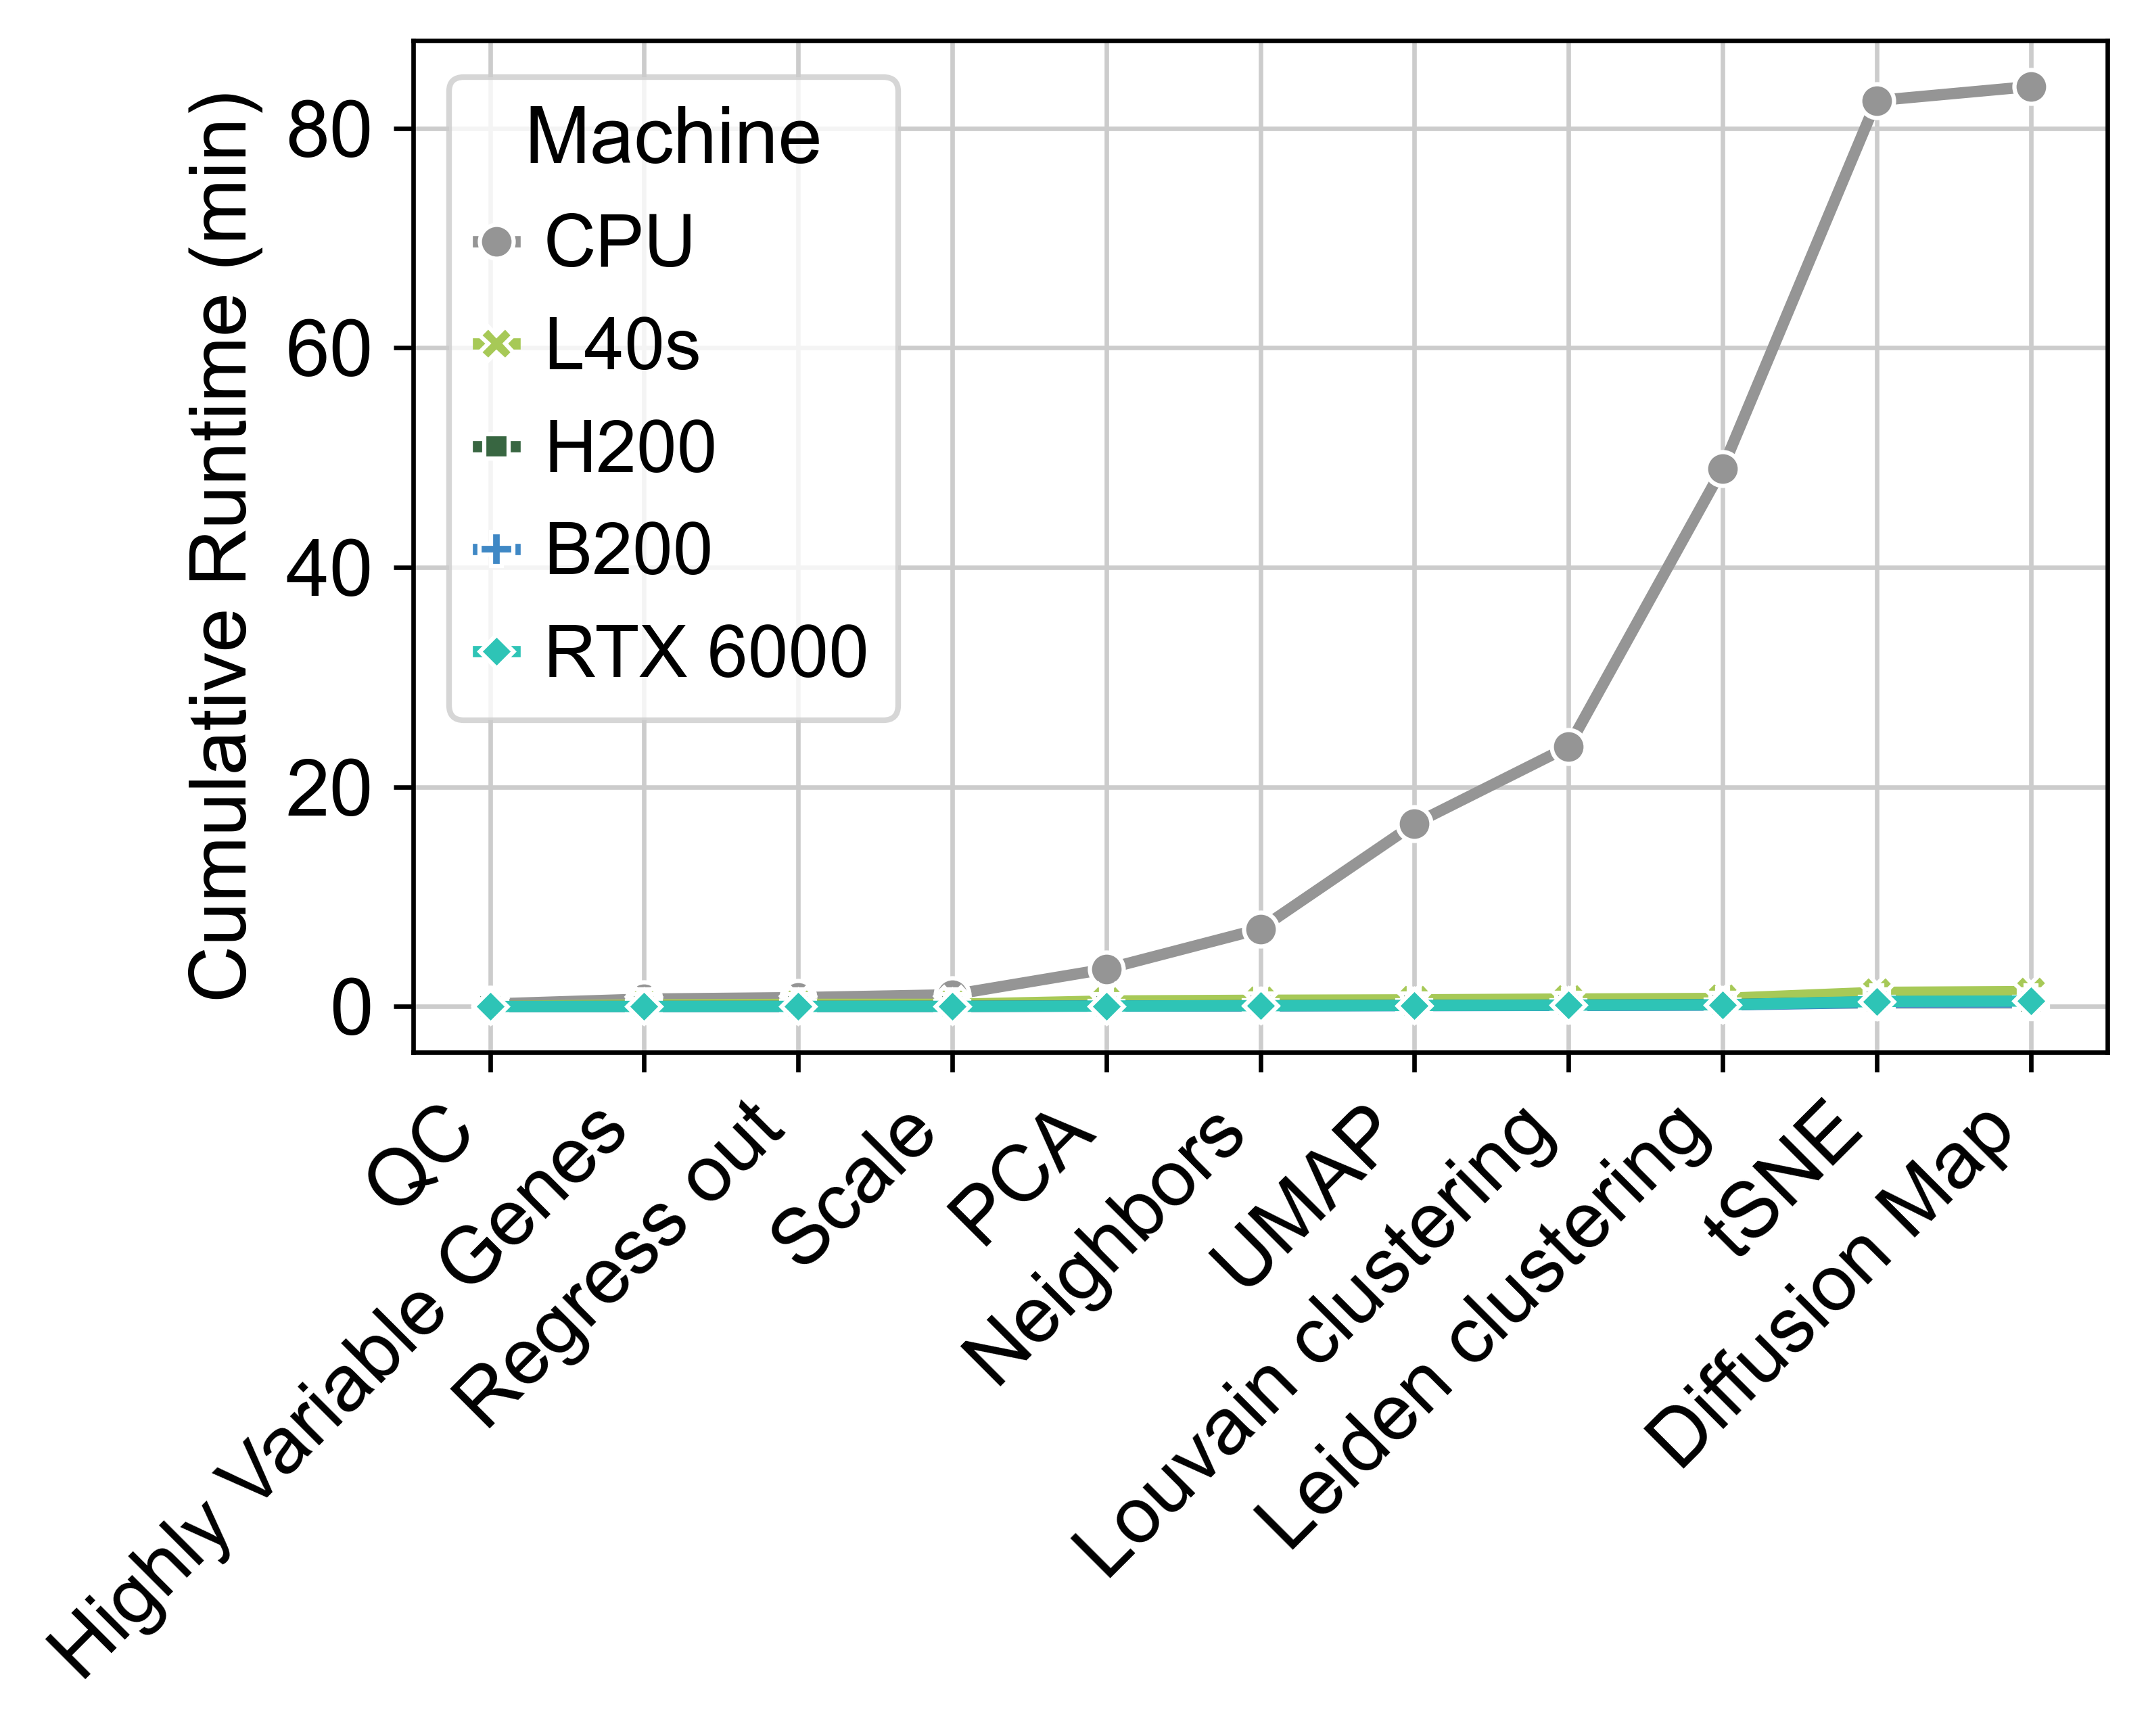

In [5]:
df = pd.read_csv("runtime_1Mcells.csv", sep=";")

exclude_rows = ["All Preprocessing", "Total Processing"]
df = df[~df.iloc[:, 0].isin(exclude_rows)]

df = df.rename(columns=lambda c: "CPU" if c.startswith("AMD") else c)
df = df.rename(columns=lambda c: "RTX 6000" if c.startswith("RTX") else c)
df.columns = df.columns.str.strip()

programs = df.iloc[:, 0]
machines = df.columns[1:]

# Convert all runtime values from milliseconds to minutes
df[machines] = df[machines].astype(float).div(1000)
df[machines] = df[machines].astype(float).div(60)

# Compute cumulative runtime for each machine
cumulative_df = df.iloc[:, 1:].cumsum()

# Prepare data for seaborn: melt to long format
cumulative_df["Program"] = programs
melted = cumulative_df.melt(id_vars="Program", var_name="Machine", value_name="Cumulative Runtime")

plt.figure(figsize=(5.5, 4.5))
sns.lineplot(
    data=melted,
    x="Program",
    y="Cumulative Runtime",
    hue="Machine",
    style="Machine",
    markers=True,
    dashes=False,
    palette=color_palette,
    linewidth=2
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Cumulative Runtime (min)")
plt.xlabel("")
plt.tight_layout()
plt.savefig("figs/runtime_1M.png")
plt.show()


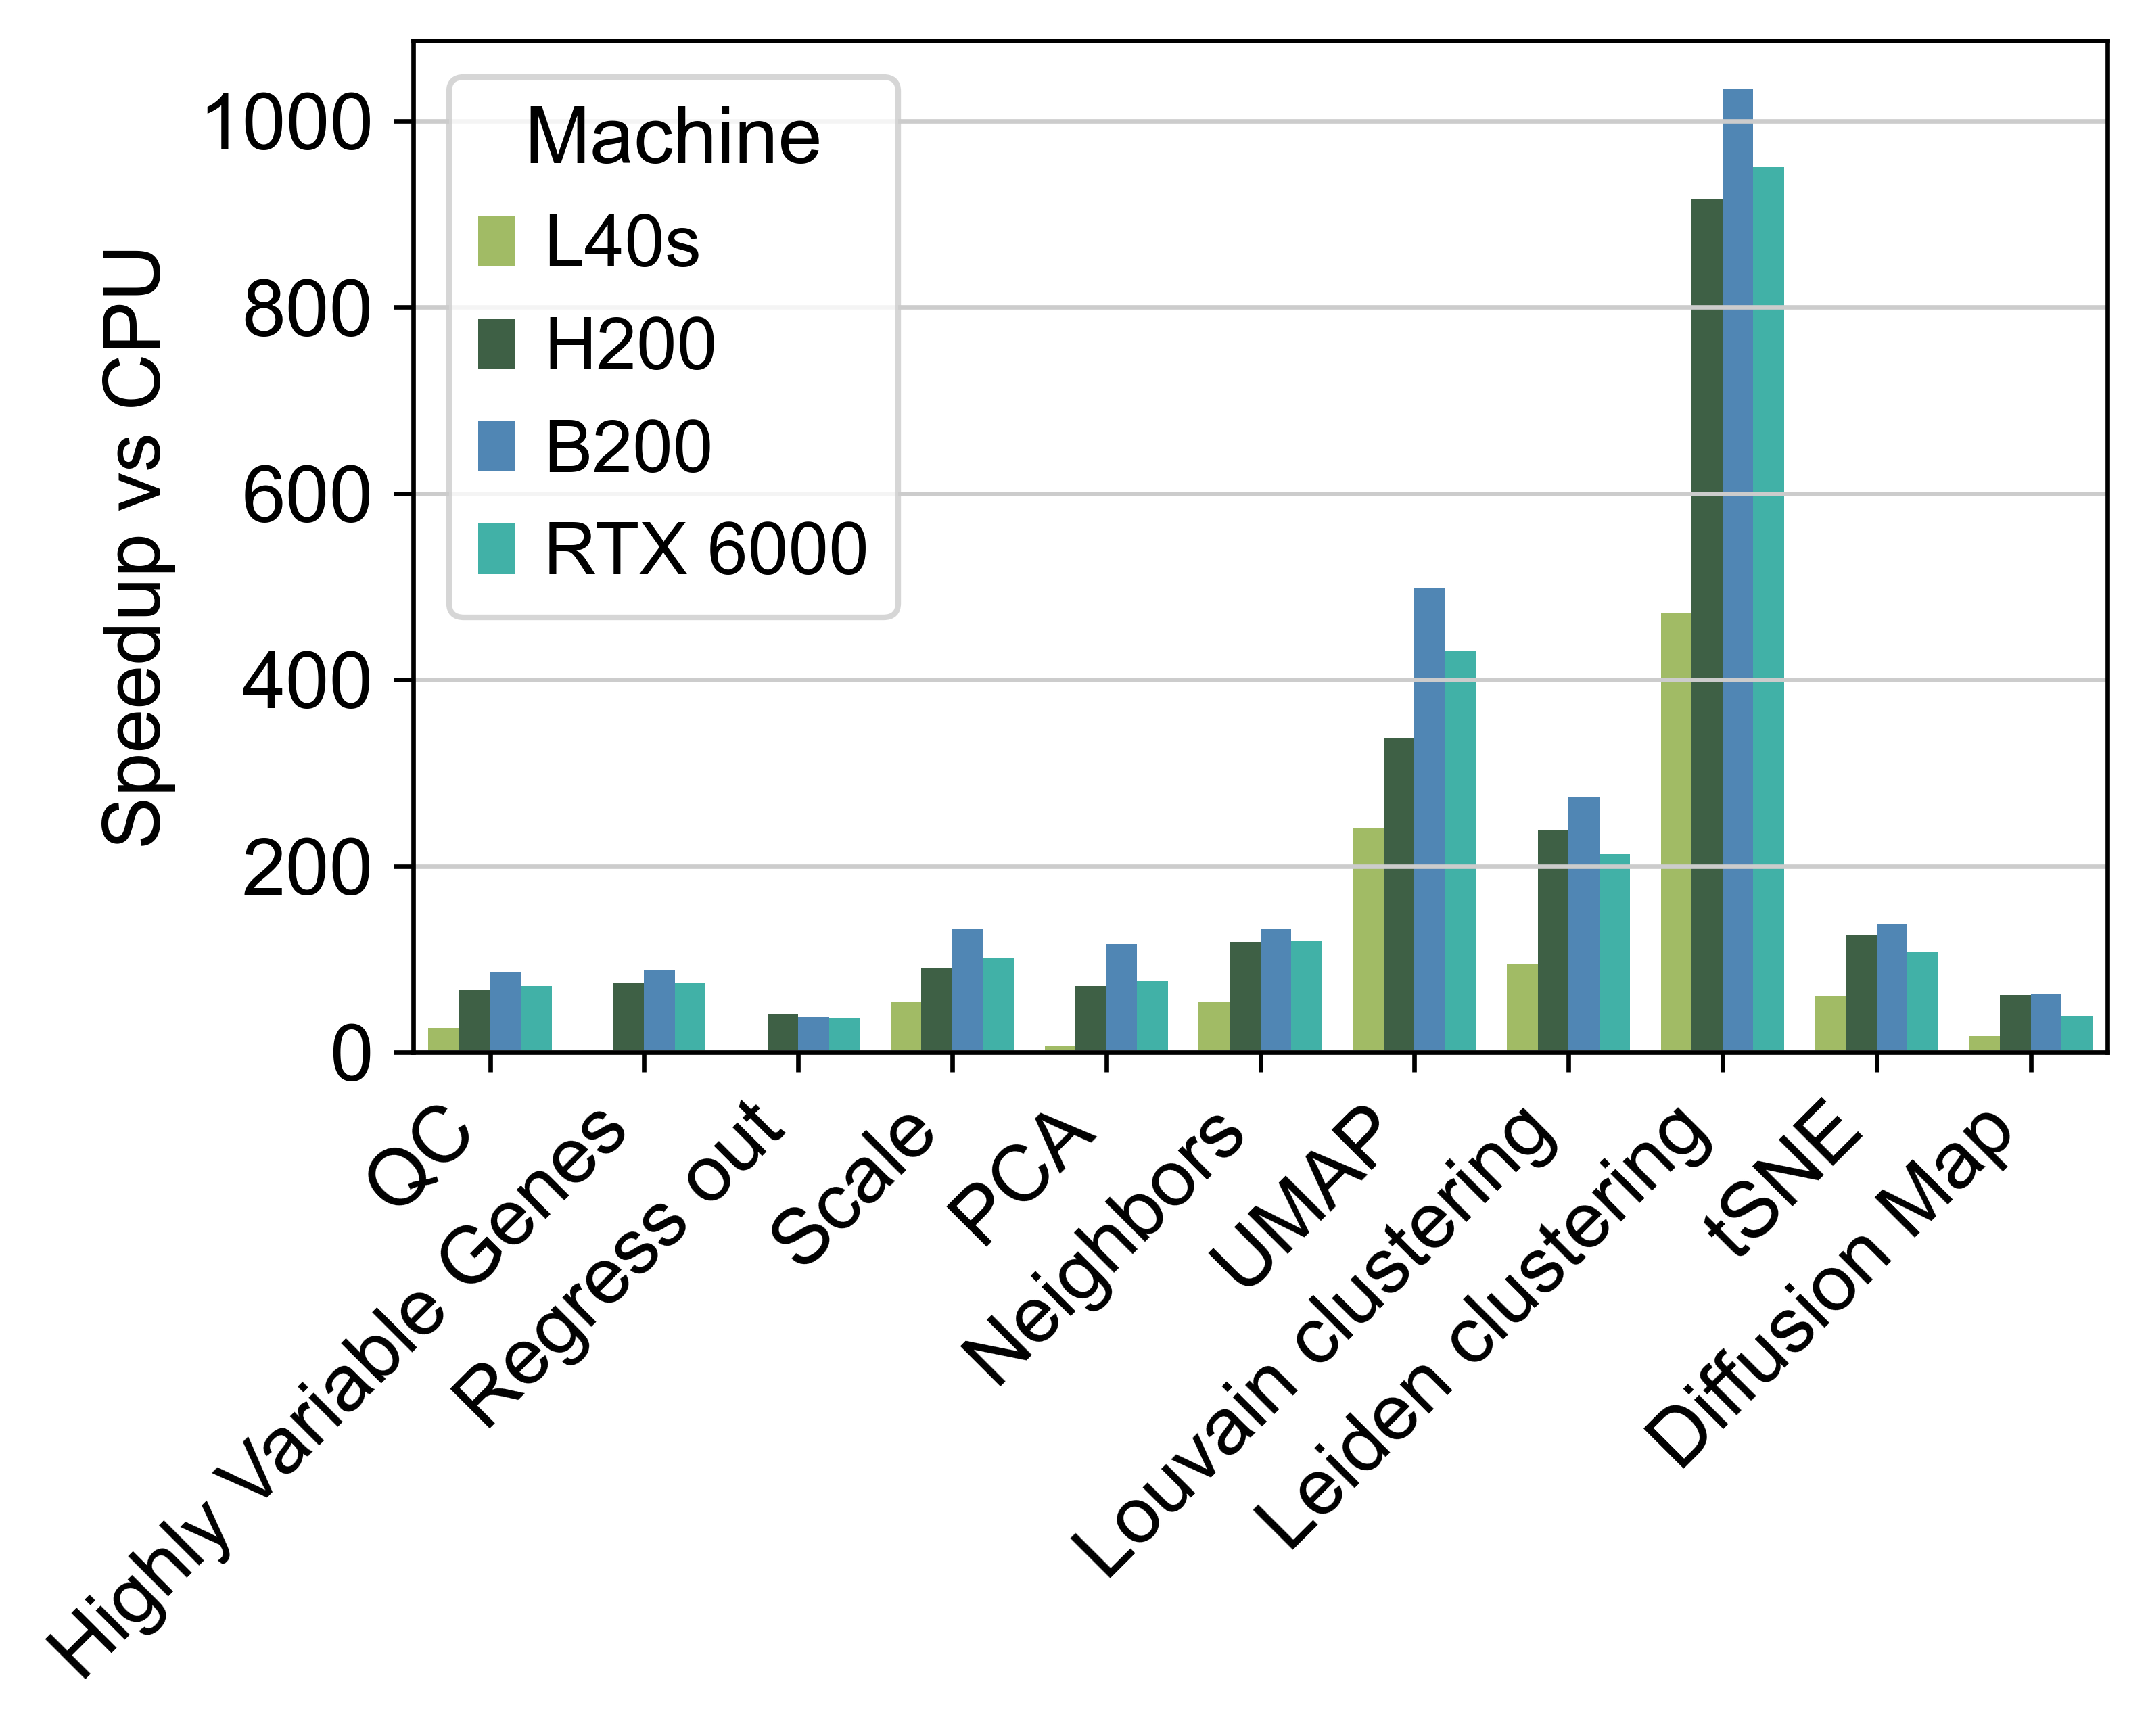

In [ ]:
# Calculate speedup compared to CPU for each machine (excluding CPU itself)
speedup_df = df.copy()
for machine in machines:
    if machine != "CPU":
        speedup_df[machine] = speedup_df["CPU"] / speedup_df[machine]

speedup_melted = speedup_df.melt(
    id_vars=df.columns[0],
    value_vars=[m for m in machines if m != "CPU"],
    var_name="Machine",
    value_name="Speedup"
)

plt.figure(figsize=(5.5, 4.5))
sns.barplot(
    data=speedup_melted,
    x=df.columns[0],
    y="Speedup",
    hue="Machine",
    palette=color_palette
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Speedup vs CPU")
plt.xlabel("")
plt.tight_layout()
plt.savefig("figs/speedup_1M.png")
plt.show()